In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance



from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


In [3]:
coluna_min_max = ["Time"]

coluna_power_transformer = ["Amount"]

target = ["Class"]

colunas_robust_scaler = [
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + target
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28']

In [40]:
X = df.drop(columns=target)
y = df[target].values.ravel()

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

In [6]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

np.float64(520.5040650406504)

In [7]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
    },
    # "SVC": {
    #     "preprocessor": preprocessamento,
    #     "classificador": SVC(class_weight="balanced", cache_size=1000),
    # },
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}

In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [10]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\viniv\anaconda3\envs\ml_kernel\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\viniv\anaconda3\envs\ml_kernel\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\viniv\anaconda3\envs\ml_kernel\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\viniv\anaconda3\envs\ml_kernel\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.039057,0.022015,0.996161,0.499034,0.0,0.0,0.0,0.498955,0.00191,0.061072
1,DummyClassifier,0.031102,0.017565,0.99657,0.499239,0.0,0.0,0.0,0.499209,0.00191,0.048668
2,DummyClassifier,0.031534,0.020034,0.995947,0.498926,0.0,0.0,0.0,0.49919,0.00191,0.051567
3,DummyClassifier,0.030809,0.01802,0.996005,0.498965,0.0,0.0,0.0,0.498887,0.001929,0.048829
4,DummyClassifier,0.032035,0.019028,0.996142,0.499034,0.0,0.0,0.0,0.504289,0.002038,0.051063
5,LogisticRegression,1.201846,0.069107,0.98328,0.935609,0.168605,0.093148,0.887755,0.985234,0.608503,1.270953
6,LogisticRegression,1.310275,0.058146,0.977785,0.958317,0.138973,0.075041,0.938776,0.987455,0.731336,1.368421
7,LogisticRegression,1.056412,0.067382,0.978545,0.958698,0.143191,0.077506,0.938776,0.978128,0.800227,1.123794
8,LogisticRegression,1.133759,0.060969,0.981292,0.940221,0.156415,0.085659,0.89899,0.97971,0.687418,1.194728
9,LogisticRegression,0.93483,0.065495,0.978252,0.95382,0.141538,0.076603,0.929293,0.981516,0.738762,1.000325


In [11]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.032907,0.019332,0.996165,0.499039,0.0,0.0,0.0,0.500106,0.001939,0.05224
LGBMClassifier,0.603188,0.0659,0.938261,0.910207,0.074547,0.039382,0.882045,0.905443,0.035513,0.669088
DecisionTreeClassifier,6.616759,0.028557,0.999158,0.87686,0.77436,0.796503,0.754092,0.87686,0.60096,6.645316
LogisticRegression,1.127424,0.06422,0.979831,0.949333,0.149744,0.081591,0.918718,0.982408,0.713249,1.191644
KNeighborsClassifier,0.392716,15.342839,0.999462,0.882054,0.844453,0.945503,0.764193,0.928754,0.818819,15.735555
XGBClassifier,0.64449,0.069332,0.999622,0.923736,0.895317,0.949773,0.847557,0.986293,0.889975,0.713822


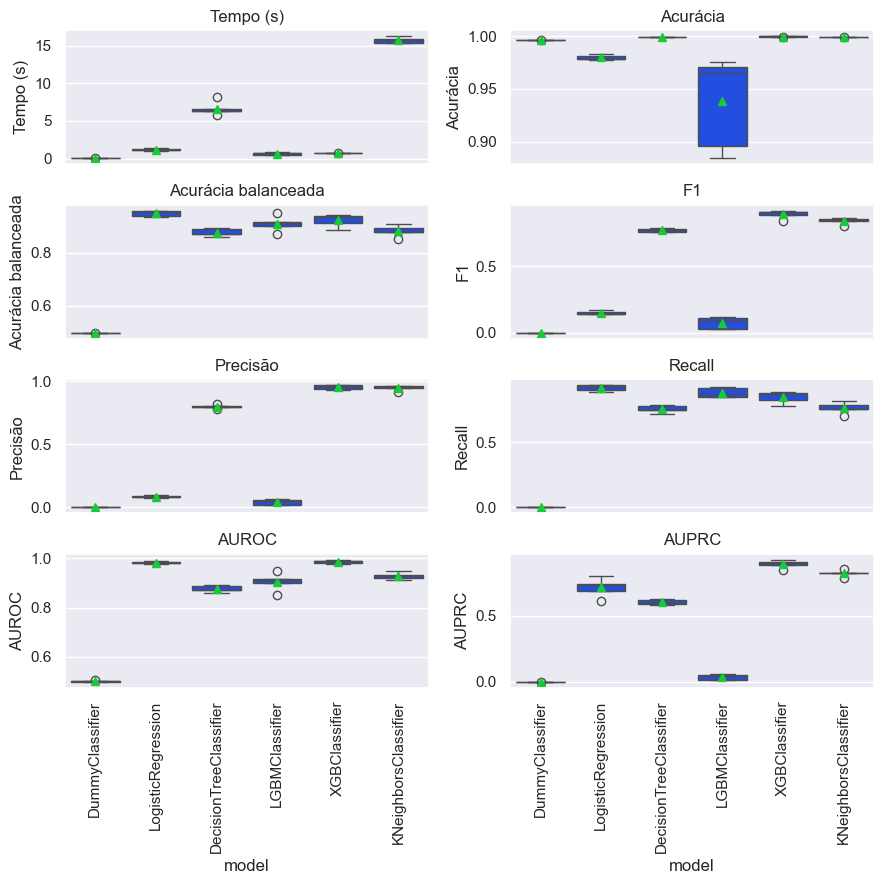

In [13]:
plot_comparar_metricas_modelos(df_resultados)

In [16]:
treinar_e_validar_modelo_classificacao(X, y, kf, **classificadores['XGBClassifier'])

{'fit_time': array([0.77053332, 0.72977972, 0.63809943, 0.60500026, 0.60052133]),
 'score_time': array([0.09300232, 0.07999945, 0.0655129 , 0.06300473, 0.06400084]),
 'test_accuracy': array([0.99945436, 0.99966872, 0.99970769, 0.99961026, 0.99966872]),
 'test_balanced_accuracy': array([0.88769653, 0.94381898, 0.93874622, 0.91411213, 0.93430438]),
 'test_f1': array([0.84444444, 0.91099476, 0.9197861 , 0.89130435, 0.91005291]),
 'test_precision': array([0.92682927, 0.93548387, 0.96629213, 0.96470588, 0.95555556]),
 'test_recall': array([0.7755102 , 0.8877551 , 0.87755102, 0.82828283, 0.86868687]),
 'test_roc_auc': array([0.97754795, 0.99096101, 0.98851886, 0.97993978, 0.99449895]),
 'test_average_precision': array([0.84433049, 0.90305055, 0.89986844, 0.88100103, 0.92162321])}

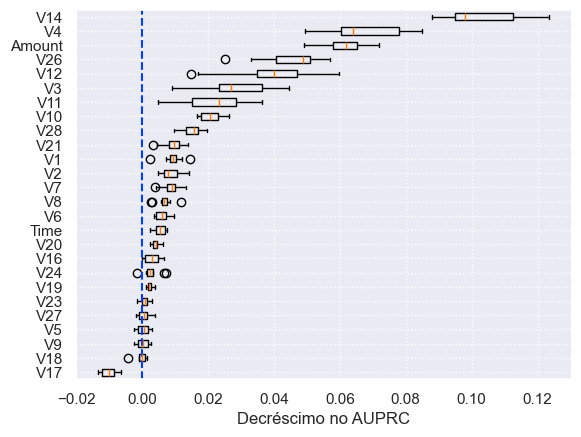

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

clf = classificadores["XGBClassifier"]["classificador"]

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision",
)

fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo no AUPRC")
ax.grid(True, linestyle=":")

plt.show()

In [27]:
X.columns[perm_imp.importances_mean < 0.01]

Index(['Time', 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V9', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V23', 'V24', 'V27'],
      dtype='object')

In [41]:
X_without_columns = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23',
       'V24', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [42]:
treinar_e_validar_modelo_classificacao(
    X_without_columns, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.3145411 , 0.31800032, 0.30499959, 0.2935164 , 0.30551338]),
 'score_time': array([0.06599832, 0.06099796, 0.06100225, 0.06299949, 0.0800004 ]),
 'test_accuracy': array([0.99941539, 0.99962975, 0.99951282, 0.99953231, 0.99949334]),
 'test_balanced_accuracy': array([0.88258473, 0.93870717, 0.91827949, 0.91911382, 0.92413504]),
 'test_f1': array([0.83333333, 0.90052356, 0.86772487, 0.87368421, 0.86597938]),
 'test_precision': array([0.91463415, 0.92473118, 0.9010989 , 0.91208791, 0.88421053]),
 'test_recall': array([0.76530612, 0.87755102, 0.83673469, 0.83838384, 0.84848485]),
 'test_roc_auc': array([0.97385246, 0.97489323, 0.98426693, 0.97711579, 0.9926295 ]),
 'test_average_precision': array([0.82628555, 0.88727911, 0.88560336, 0.87943563, 0.88295909])}

In [30]:
param_grid = {
    "clf__max_depth": [3, 6, 10],  # Profundidade da árvore
    # "clf__min_child_weight": [1, 3, 5],  # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3],  # Redução mínima de perda para uma divisão
    "clf__subsample": [0.6, 0.8, 1.0],  # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para cada árvore
    # "clf__learning_rate": [0.1, 0.3, 0.5],  # Taxa de aprendizado
    # "clf__n_estimators": [10, 50, 100],  # Número de árvores
    "clf__reg_lambda": [1, 2, 5],  # Regularização L2
    "clf__reg_alpha": [0, 0.5, 1],  # Regularização L1
    # "clf__scale_pos_weight": [1, scale_pos_weight],  # Peso das classes
}

In [31]:
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, None, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

### Test 

with columns

In [52]:
grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [53]:
grid_search.best_params_

{'clf__colsample_bytree': 0.8,
 'clf__max_depth': 6,
 'clf__reg_alpha': 0,
 'clf__reg_lambda': 5,
 'clf__subsample': 1.0}

In [54]:
grid_search.best_score_

np.float64(0.8980043496145482)

without columns

In [49]:
#grid_search.fit(X_without_columns, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [50]:
#grid_search.best_params_

{'clf__colsample_bytree': 0.8,
 'clf__max_depth': 10,
 'clf__reg_alpha': 1,
 'clf__reg_lambda': 5,
 'clf__subsample': 1.0}

In [51]:
#grid_search.best_score_
#np.float64(0.8786169702179782)

np.float64(0.8786169702179782)

### Results

In [55]:
grid_search.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [56]:
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]

for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.9995751812300255
mean_test_balanced_accuracy: 0.9216959219897959
mean_test_f1: 0.8835788432722488
mean_test_precision: 0.9292196117859417
mean_test_recall: 0.8435168006596578
mean_test_roc_auc: 0.9863855103370224
mean_test_average_precision: 0.8980043496145482


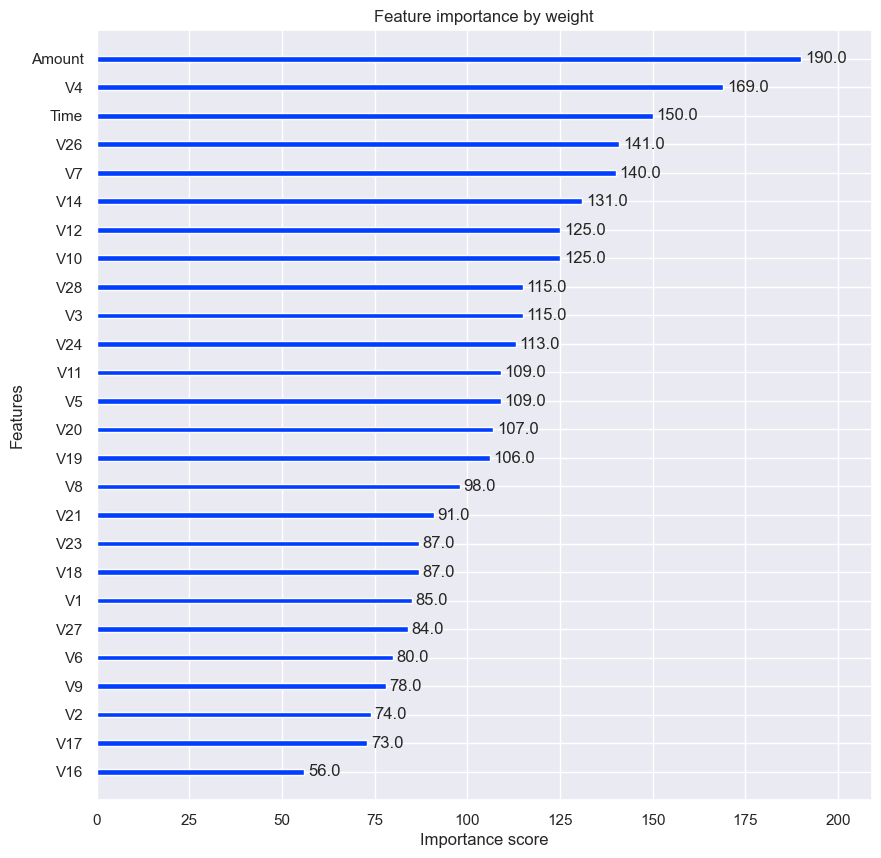

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight",
    title="Feature importance by weight"
)

plt.show()

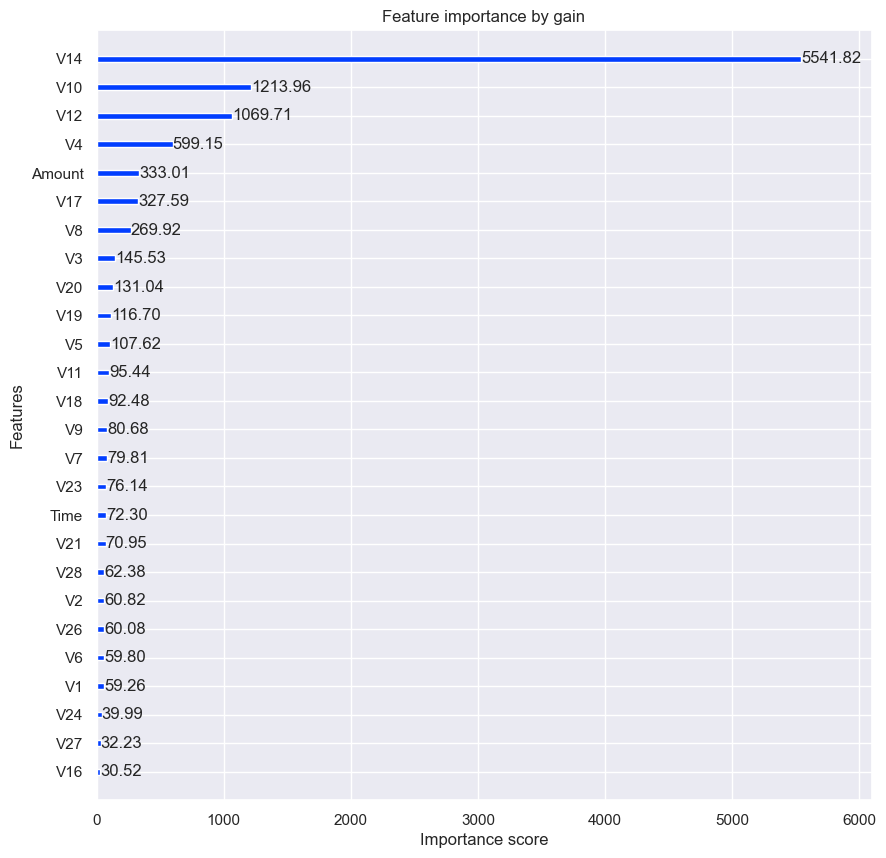

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain",
    title="Feature importance by gain",
    values_format="{v:.2f}"
)

plt.show()